# AI・機械学習 勉強会 #1
## - 多層パーセプトロンおよび畳み込みニューラルネットワークによる画像分類 -


※このjupyter notebookは、東京大学 松尾研究所が公開している[DL4USコンテンツ](https://weblab.t.u-tokyo.ac.jp/dl4us/)をベースに、理論よりも実践をベースにTry & Errorによる理解を深める形式で改良を加えています。



## 目次

- 1.1 概要
- 1.2 実装プロセス
- 1.3 各モデルLayer
- 1.4 損失関数
- 1.5 評価関数
- 1.6 Functional API
- 1.7 確認問題



---



##1.1 概要
Tensorflow + Kerasによる実装を通じて基本的なDeep Learningの考え方や実装方法を学習します。

また、画像分類における多層パーセプトロン(MLP)と畳込みニューラルネットワーク(CNN)での比較を行い、モデル構造の違いとチューニングパラメータについて理解を深めます。




---



## 1.2 実装プロセス

ここでは、画像分類をMLP(Multi Layer Perceptron)とCNN(Convolutional Neural Network)の2つモデルにいて、教師あり学習モデルの実装およびモデル構造、学習結果の比較をしてみます。

実装に使用する題材は、MNIST(手書き数字画像)と、CIFAR10(乗り物や動物などの画像)の2種類とします。


参考：https://keras.io/ja/datasets/

### 1.2.1 環境準備

プログラムを動かすにあたって、モデルおよびデータセットを指定してください。

<モデル構造>
* MLP
* CNN

<データセット>
* MNIST
* CIFAR10


また、このjupyter notebookはtensorflow 1.13.1を前提に実装しています。2019/6/14時点でバージョンが変更(1.14)となったため、ダウングレードしておきます。


In [1]:
# ライブラリのバージョン調整
# 2019/6/14時点でデフォルトのTensorflowバージョンが変わった模様
!pip install tensorflow-estimator==1.13.0 tensorflow-gpu==1.13.1

# モデル構造を指定します (MLP or CNN)
model_structure="CNN"
# データセットを指定します (MNIST or CIFAR10)
data_set="MNIST"

     |████████████████████████████████| 368kB 2.9MB/s 
     |████████████████████████████████| 345.2MB 49kB/s 
ERROR: tensorflow 1.14.0rc1 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.14.0rc0
    Uninstalling tensorflow-estimator-1.14.0rc0:
      Successfully uninstalled tensorflow-estimator-1.14.0rc0


### 1.2.2 データの準備
教師あり学習を行う場合、学習させるデータを用意する必要があります。

MNISTおよびCIFAR10はKerasにて提供されていますので、ここではこちらを使います。

なお、データの収集は非常に地味かつ大変な作業ですが、このデータの事前準備が非常に重要であり、"使える"データの量や種類が、モデルの精度に大きく関わってきます。

今回は用意されたものを使いますが、自分で集めたデータセットにて学習させることも非常に良い経験となるため、ぜひご自身でもトライしてみてください。
         
今回扱うMNISTおよびCIFAR10のデータ構造は下記となっています。

* x：画像(MNIST：28×28x1、CIFAR10：32x32x1) ※縦x横xグレー(1)orカラー(3)
* y：正解のラベル(xの画像が表す意味)

また、これらデータセットは学習用と評価用に最初から分割されています。

* (x_train, y_train):モデルの学習用
* (x_test, y_test):モデルの評価用

Deep Learningでは汎化性能の向上が至上命題なので、学習用のデータだけでなく評価用のデータが必要になります。

なぜなら、評価用のデータまで使用して学習してしまうのは、カンニングしていることと同義だからです。


In [2]:
# Kerasにて用意されているデータセットをダウンロードします
from tensorflow.keras.datasets import mnist
from keras.datasets import cifar10

# MNIST
if data_set == "MNIST":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    img_size,img_color=28,1
# CIFAR10
else:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    img_size,img_color=32,3

    8192/11490434 [..............................] - ETA: 0s

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(y_test[1])

2


ダウンロードした画像と画像に対応したラベルを表示してみます。

表示する際には、matplotlibを用います。これはPythonでグラフの表示をする際に標準的に用いられるライブラリです。

中でもpyplotは最もよく使用されるモジュールで、標準的な描画処理の多くに対応しています。

ここでは詳しくは説明しませんが、公式のマニュアルでpyplotに含まれる関数に目を通しておくことをお勧めします。

参考：https://matplotlib.org/api/pyplot_api.html

なお、jupyer notebook上でmatplotlibの結果を表示するには、`%matplotlib inline`を冒頭で宣言する必要があります。

（ちなみに、このような`%`あるいは`%%`から始まるjupyter notebookに対するコマンドはマジックコマンドと呼ばれ、他にも様々なものが存在します。）

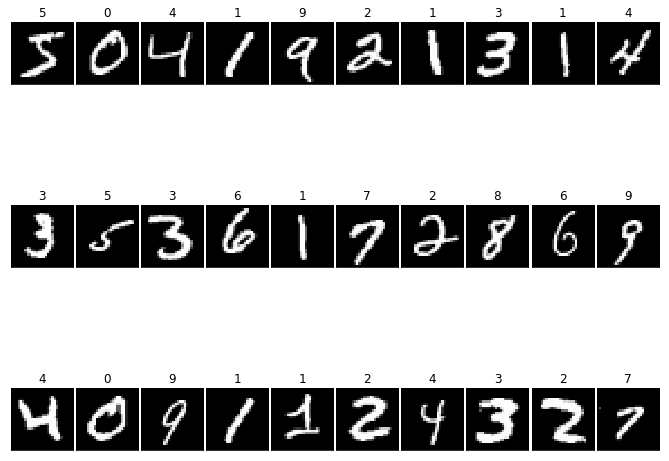

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

これから実施するのは、MINISTにしても、CIFAR10にしても、いわゆる10クラス分類の問題です。（分類先のことを**クラス**と呼びます）

さて、ここで特に分類タスクの際に気をつけたいことが2つあります。



1.   ラベルの意味

        MNISTにおいては、ラベルの値が数字としての意味と一致しているように見えますが、これはただの偶然でしかなく、あくまで、ラベルの値はクラスのインデックスに過ぎない数値ということです。

        CIFAR10で試してみるとわかりますが、飛行機の画像のラベルは"0"であってairplaneという意味を持っているわけではありません。

        要するに、Deep Learningとして理解している(させている)わけではないということです。

        後ほど実装内にも出てきますが、各インデックスの意味づけは人がプログラム内でつけることなります。

        画像分類の問題に限らず、現在のDeep Learningにおいては、1次的な結果を学習させ人間を超える精度を発揮することは可能ですが、2次的情報を付加するのはあくまで人間であり、その情報を理解し拡張することはまだできないと認識しておいてください。


2.   ラベルの表現

        もう一つ、インデックスなので、データとしては数字で表現されてしまいますが、Deep Learningを行う上で、これを数字としての意味を持って扱ってもらっては困るため、全クラス中のどのクラスに該当するかという表現に置き換える必要があります。

        これを**one-hot表現**と呼んでいます。

        * ラベル 0 = airplane -> (one-hot表現) -> [1,0,0,0,0,0,0,0,0,0]  ※10要素の配列の0番目に該当
        * ラベル 1 = car -> (one-hot表現) -> [0,1,0,0,0,0,0,0,0,0] ※10要素の配列の1番目に該当

    このone-hot表現への変換を行ってくれる関数がKerasにはあります。
    
    keras.utils.to_categorical関数がその関数です。データセット(y_trainおよびy_testにも適用してみましょう。
    https://keras.io/ja/utils/#to_categorical

In [0]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# 名義尺度の値をone-hot表現へ変換 (10クラス)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

MLPでは、画像上の位置情報を意識せず、１次元配列として次の層に全結合させていきます。

一方、CNNは画像の位置情報を保持した３次元配列のまま、ConvolutionおよびPoolingすることで特徴量を抽出します。

そのため、学習および推論する際のINPUTデータ形式は、MLPは１次元配列、CNNは３次元配列となります。

In [0]:
# 画像データの形式をMLPおよびCNNに適した形に修正
# for CNN 
if model_structure=="CNN":
    x_train = x_train.reshape(-1, img_size, img_size, img_color).astype(np.float32)
    x_test = x_test.reshape(-1, img_size, img_size, img_color).astype(np.float32)
    input_shape = (img_size, img_size, img_color)
# for MLP        
else:
    # 入力画像を行列(28x28)からベクトル(長さ784)に変換
    x_train = x_train.reshape(-1, img_size*img_size*img_color)
    x_test = x_test.reshape(-1, img_size*img_size*img_color)
    input_shape = (img_size*img_size*img_color,)


### 1.2.3 モデル構築

学習に使用するMLPのモデルを構築します。具体的には、どんなlayer（層）をどこに配置するか、また各layerのユニット数はいくつかを指定していきます。

このモデルを構築するための「容器」として機能するのが、keras.models.Sequentialクラスです。

この「容器」の中に、Sequential.add関数によってkeras.layersに定義されているlayerクラス（後で詳述）を積み重ねていくことでモデルの構築を行います。

https://keras.io/ja/models/sequential/

In [0]:
# モデル構築用ライブラリをインポート
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

# CNNモデル用ライブラリ
from tensorflow.python.keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.python.keras import initializers

# モデルの「容器」を作成
model = Sequential()

モデル構造を定義します。モデルの切り替えが用意にできるように、ここではモデル構造ごとにfunctionを用意しておきます。

なお、Kerasでは最初のLayerにてInput_shapeを定義する必要があります。

下記実装においては、入出力を除いた中間層について、MLPは全結合2層、CNNは畳込み2層＋全結合1層としています。

各レイヤーのパラメータ等についてはKerasのドキュメントを参照してください。

* [Dense/Actication/Dropout](https://keras.io/ja/layers/core/)
* [Conv2D](https://keras.io/ja/layers/convolutional/)
* [MaxPooling](https://keras.io/ja/layers/pooling/)
* [Batch Normalization](https://keras.io/ja/layers/normalization/)


MLPにおいては、3つの異なる活性化関数(Activation)のfunctionを用意しています。

また、CNNにおいては、Dropoutの有無とBatch Nrmalizationを実装したfunctionを用意しています。

それぞれのモデルの比較とともに、層の深さやレイヤーの構成、レイヤーごとのパラメータなどを自由にいじってみて、どのような変化が起こるか試してみましょう。


In [0]:
# MLPモデル
def mlp_relu_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dense(units=100))
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

def mlp_sigmoid_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('sigmoid'))
    model.add(Dense(units=100))
    model.add(Activation('sigmoid'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

def mlp_tanh_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(Dense(units=100))
    model.add(Activation('tanh'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))


In [0]:
# CNNモデル
def cnn_model():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

# CNNモデル w/Dropout
def cnn_w_dropout():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))
    
# CNNモデル w/Batch Normalization
def cnn_w_batchnorm():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

それでは、任意のモデルを選び、構築してみましょう。

In [10]:
# model構築
if model_structure=="CNN":
#    cnn_model()
#    cnn_w_dropout()
    cnn_w_batchnorm()
else:
    mlp_relu_model()
#    mlp_sigmoid_model()
#    mlp_tanh_model()

Instructions for updating:
Colocations handled automatically by placer.


視覚的にわかるよう、モデル構造を図示します。

また、同時に各レイヤーの定義情報を参考として出力してみます。

Cloning into 'convert_drawer'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 289 (delta 42), reused 50 (delta 22), pack-reused 219
Receiving objects: 100% (289/289), 959.57 KiB | 16.26 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Conv2D {'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'TruncatedNormal', 'config': {'mean': 0.0, 'stddev': 0.1, 'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Activation {'name': 'activation',

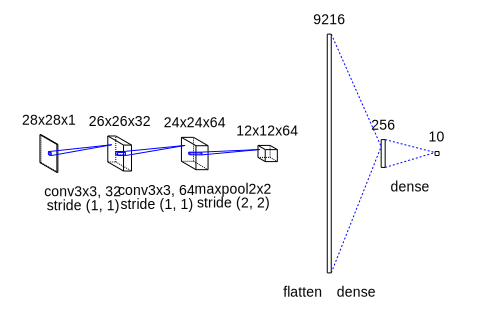

In [11]:
!git clone https://github.com/scpepper69/convnet-drawer.git convert_drawer
import sys
sys.path.append('./convert_drawer/')
from keras_util import convert_drawer_model
from keras_models import AlexNet
from matplotlib_util import save_model_to_file
from IPython.display import *

# get Keras sequential model
#keras_sequential_model = AlexNet.get_model()
draw_model = convert_drawer_model(model)

# save as svg file
draw_model.save_fig('model_structure.svg')
display_svg(SVG('model_structure.svg'))


layerをSequentialクラスに積み終えたら、最後にSequential.compile関数でモデルの学習処理について指定し、モデル構築は完了です。

compile関数では

* optimizer（最適化手法）
* loss（損失関数）
* metrics（評価関数（任意））

を指定することになります。（いずれも後で詳述）


In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
# モデルの学習方法について指定しておく
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(lr=0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adamax(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=0.001), metrics=['accuracy'])


モデル構造や結果等の視覚化することで、何がどのように動いているのか、理解の手助けとなります。

このjupyter notebook上でも可視化ロジックを組み込んでいますが、TensorBoardという手段もあります。

TensorBoardでも参照できるよう、設定を組み込んでおきます。

In [0]:
# TensorBoardでの可視化のため、出力先の設定
import os, shutil
if os.path.exists("./logs"):
    shutil.rmtree("./logs")

from tensorflow.keras import callbacks
tb_cb = callbacks.TensorBoard(log_dir="./logs/", histogram_freq=1,write_images=1)

チェックポイントを生成しておくことで、中断した学習の再開や、チェックポイントを利用した静的モデルの出力を行うことができます。

In [0]:
!mkdir model
checkpoint_path = "model/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_cb = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=5)

学習の実行の前に、モデルのサマリ情報を確認してみましょう。

In [15]:
# モデルのサマリ情報の表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
__________

### 1.2.4 モデルの学習

1.2.3で構築したモデルで実際に学習を行うには、Sequential.fit関数を用います。この関数は固定長のバッチで学習を行います。

主な引数は次の通りです。

* x：学習に使用する入力データ
* y：学習に使用する出力データ
* batch_size：学習中のパラメータ更新を1回行うにあたって用いるサンプル数（ミニバッチのサイズ）
* epochs：学習のエポック数
* verbose：学習のログを出力するか（0:しない、1：バーで出力、2:エポックごとに出力）
* validation_split/validation_data：検証用に用いるデータの割合（0～１の実数）、または検証用データそのもの（いずれかのみ指定可能）
* shuffle：各エポックごとにデータをシャッフルするか
* callbacks：訓練中のモデルの挙動を監視できるcallback関数を指定できます

In [16]:
# epoch数を指定
epochs=10

# 学習の実行
result = model.fit(x_train, y_train,
          batch_size=1000, epochs=epochs, verbose=1,callbacks=[tb_cb, cp_cb],
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 53s 876us/sample - loss: 0.2986 - acc: 0.9103 - val_loss: 0.5038 - val_acc: 0.8847
Epoch 2/10
60000/60000 [==============================] - 48s 800us/sample - loss: 0.1043 - acc: 0.9714 - val_loss: 0.1302 - val_acc: 0.9576
Epoch 3/10
60000/60000 [==============================] - 47s 784us/sample - loss: 0.0759 - acc: 0.9803 - val_loss: 0.0802 - val_acc: 0.9756
Epoch 4/10
60000/60000 [==============================] - 47s 775us/sample - loss: 0.0600 - acc: 0.9849 - val_loss: 0.0617 - val_acc: 0.9807
Epoch 5/10
59000/60000 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9883
Epoch 00005: saving model to model/cp-0005.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
60000/60

モデルの評価を行うには、Sequential.evaluate関数を用います。この関数は固定長のバッチごとに損失関数値または評価関数値を出力します。

主な引数は次の通りです。

* x：評価に使用する入力データ
* y：評価に使用する出力データ
* batch_size：1回の評価を行うにあたって用いるサンプル数
* verbose：評価のログを出力するか（0:しない、1：する(デフォルト)）

基本的には、損失(Loss)は低ければ低いほうが、評価(Accuracy)は高ければ高いほうが良いです。


In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03994139395225793
Test accuracy: 0.9873


epochごとのAccuracyおよびLossの遷移をグラフ化してみましょう。

fit関数のreturnから、データを取得することができます。

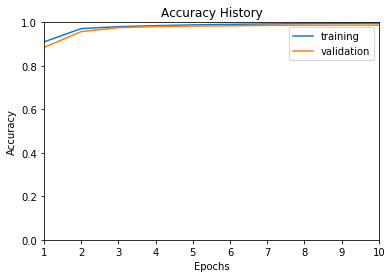

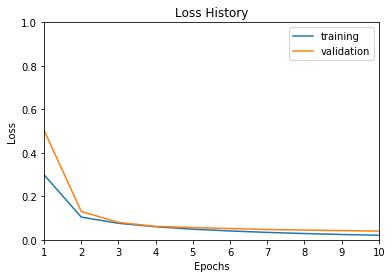

In [18]:
result.history.keys() # ヒストリデータのラベルを見てみる
plt.plot(range(1, epochs+1), result.history['acc'], label="training")
plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,1])
plt.show()

plt.plot(range(1, epochs+1), result.history['loss'], label="training")
plt.plot(range(1, epochs+1), result.history['val_loss'], label="validation")
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,1])
plt.show()


### 1.2.5 モデルによる予測

1.2.4で学習させたモデルによって予測を行ってみましょう。Sequential.predict関数によって予測が行えます。

主な引数は次の通りです。

* x_test：予測に使用する入力データ
* batch_size：まとめて1度に予測を行うサンプル数
* verbose：評価のログを出力するか（0:しない(デフォルト)、1：する）

In [19]:
classes = model.predict(x_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 0s 30us/sample


上記コマンドで検証用データ10000件の予測を実施しています。

これだけでは何ができたのかよくわからないので、画像を1枚抽出して、その結果を見てみます。

モデル構築の際に、いずれのモデルにおいても、出力層をDense(10)、Activation('softmax')としていました。

これは、10クラス(Dense(10))に、それぞれの確からしさを出力(Activation('softmax'))する、という意味になります。

softmaxでは、すべてのクラスの出力値の合計が1になります。そのため、この値が確からしさそのものを指し、最も値の大きいラベルが推論結果として採用することとなります。


なお、前述(1.2.2)にてラベルの意味づけに言及していましたが、本サンプルでは、ここでラベルの数値をラベルの意味に変換させています。

クラスごとの確からしさ(%)：[ 0.        0.        2.        0.       58.999996  0.       38.
  0.        0.        0.      ]
推論結果：4


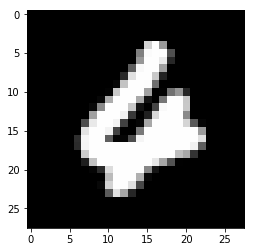

In [20]:
# データセットの推論結果と元画像を確認
# test_numを0～9999で指定してください
%matplotlib inline
test_num=1112
test_img = np.squeeze(x_test[test_num])
if not model_structure=="CNN":
    test_img = np.squeeze(test_img.reshape(img_size, img_size, img_color).astype(np.float32))

if data_set=="MNIST":
    labels = np.array([0,1,2,3,4,5,6,7,8,9])
else:
    labels = np.array([
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])

print("クラスごとの確からしさ(%)："+str(np.round(classes[test_num],decimals=2)*100))

print("推論結果："+str(labels[classes[test_num].argmax()]))
plt.imshow(test_img.astype(np.int),'gray')
plt.show()

事前に準備された画像データだけでは面白味もないので、自分で画像を用意し、推論させてみましょう。

手書き画像(MNISTの場合)や、Web検索で画像を取得し、Google Colabにアップロードしてみましょう。

私が用意したサンプルデータも用意しておきます。

In [21]:
# サンプルデータのダウンロード
!wget https://raw.githubusercontent.com/scpepper69/dl4us/master/lesson1/mnist.zip
!unzip mnist.zip

--2019-06-14 11:27:35--  https://raw.githubusercontent.com/scpepper69/dl4us/master/lesson1/mnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3365 (3.3K) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]   3.29K  --.-KB/s    in 0s      

2019-06-14 11:27:35 (82.9 MB/s) - ‘mnist.zip’ saved [3365/3365]

Archive:  mnist.zip
  inflating: five001.png             
  inflating: four001.png             
  inflating: nine001.png             
  inflating: one001.png              
  inflating: seven001.png            
  inflating: six001.png              
  inflating: three001.png            
  inflating: two001.png              
  inflating: zero001.png             
  inflating: eight001.png            


ファイルをアップロードし終えたら、ファイル名を指定して推論してみましょう。

784
1/1 [==============================] - 0s 6ms/sample
クラスごとの確からしさ(%)：[[ 0.  0.  0.  0. 98.  0.  0.  0.  1.  0.]]
推論結果：4


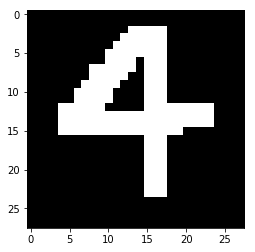

In [22]:
import cv2
    
# Google Colabにファイルをアップロード
# アップロードしたファイルを指定
img_path="./four001.png"

if data_set=="MNIST":
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = 255 - img #白黒反転
else:
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)

plt.imshow(img,'gray')
    
img = cv2.resize(img, dsize=(img_size,img_size)) # 28 x 28にサイズ変更
img = img.astype(np.float32)
print(img.size)

if model_structure=="CNN":
    img = img.reshape(1, img_size, img_size ,img_color) # 2次元から4次元に変換
else:    
    img = img.reshape(1, img_size*img_size*img_color).astype(np.float32)

pred = model.predict(img,verbose=1)

# 推論処理
print("クラスごとの確からしさ(%)："+str(np.round(pred,decimals=2)*100))
print("推論結果："+str(labels[pred.argmax()]))

### 1.2.6 中間層データの可視化

ここまでで、データを準備し、モデルを構築し、学習、推論させることができました。

どのように実装し、どのように使うのか、簡単にイメージすることができたのではないでしょうか。

この項では、モデルがどのように動きているか理解を深めるために、中間層のデータを見てみます。

ただ、MLPでは1次元に変換してしまっているので、見てもよくわからないかもしれませんが。

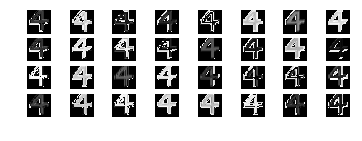

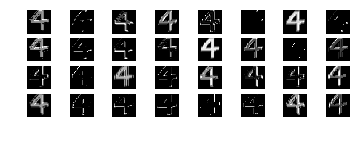

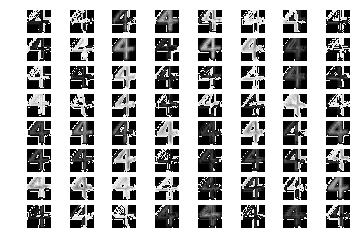

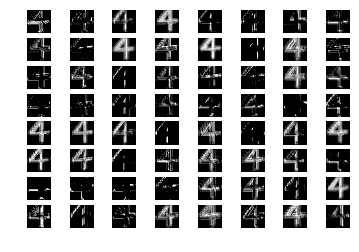

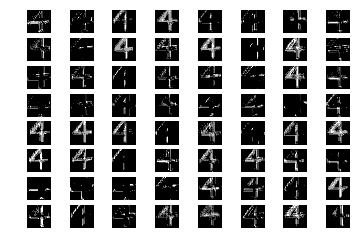

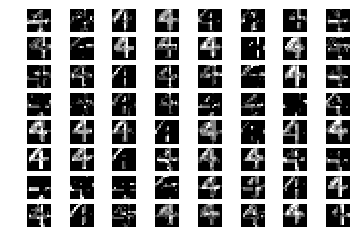

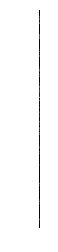

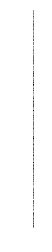

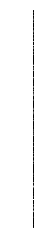

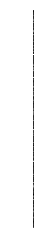

In [23]:
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image

# 中間層の特徴マップを出力する
def middle_layer_output(numlay, INPDATA):
    get_layer = K.function([model.layers[0].input], [model.layers[numlay].output])
    layer_output_comp = get_layer([INPDATA])[0]
    if layer_output_comp.ndim == 4:
        dim_n = layer_output_comp.shape[0]
        dim_x = layer_output_comp.shape[1]
        dim_y = layer_output_comp.shape[2]
        dim_z = layer_output_comp.shape[3]
    else:
        dim_n = layer_output_comp.shape[0]
        dim_z = layer_output_comp.shape[1]

    #中間層の出力を図化する
    plt.figure()
    for num_pic in range(dim_n):
        if layer_output_comp.ndim == 4:
            for num_map in range(dim_z):
                img = layer_output_comp[num_pic, :, :, num_map]
                img = Image.fromarray(np.uint8(img))
                plt.subplot(8,8,num_map+1)
                plt.axis('off')
                plt.imshow(img, cmap='gray')
    
        else:
#            dims = int(np.sqrt(len(layer_output_comp[0])))
            dims = int(len(layer_output_comp[0]))
            img = layer_output_comp[num_pic, :]
#            img = img.reshape(dims, dims).astype(np.float32)
            img = img.reshape(dims, 1).astype(np.float32)
            plt.axis('off')
            plt.imshow(img, cmap='gray')

# レイヤーごとの特徴マップの出力
for layers in range(len(model.layers)-2):
    middle_layer_output(layers, img)


CNNでは、ConvolutionおよびMaxPoolingでの特徴量の抽出の特性がイメージできたでしょうか。

Deep Learningモデルにおいては、INPUTに対する最終的なOUTPUTだけでなく、中間層のOUTPUTを自由に取得することができるという点も非常に重要な特性であることは覚えておいてください。

また、OUTPUTの観点だけでなく、INPUTも同様で、中間層にINPUTし、OUTPUTを得ることもできます。


jupyter notebook上でモデル構造など可視化させてきましたが、TensorBoardでもどのように見えるのか試してみましょう。

Google Colabでは、直接HTTPアクセスはできないので、ngrokを用いて参照させます。

下記コード実行後し、出力されるURLにアクセスしてみましょう。

In [24]:
# Web参照のため、ngrokを利用
if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

# TensorBoardおよびngrokの起動
import subprocess
cmd = "tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &"
proc_tb = subprocess.call(cmd, shell=True)

cmd = "./ngrok http 6006 &"
proc_ng = subprocess.call(cmd, shell=True)

# TensorBoard URL
!curl -s http://localhost:4040/api/tunnels | python -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-06-14 11:27:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.209.102.29, 52.71.139.107, 34.231.75.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.209.102.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  71.3MB/s    in 0.2s    

2019-06-14 11:27:51 (71.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://3d28d22b.ngrok.io


In [25]:
# TensorBoardプロセスの停止
#!ps -ef | grep tensorboard | grep -v grep | awk '{print "kill -9",$2}'| sh

# ngrokプロセスの停止
#!ps -ef | grep ngrok | grep -v grep | awk '{print "kill -9",$2}'| sh
!mkdir model

mkdir: cannot create directory ‘model’: File exists


### 1.2.7 モデルの出力

学習させたモデルを出力し、静的学習済みモデルとして外部で活用することもできます。

ここでは、活用の汎用性を考えてTensorFlowのプロトコルバッファ形式にて出力してみます。

静的学習済みモデルは、プログラムで読み込んで使うことも、GraphPipeやTensorFlow Serving等のモデルサーバーを用いてAPI化して利用することもできます。

Google ColabではDockerを扱うことができないので、ローカルPCやクラウド環境等で試してみてください。

In [27]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow import identity

# 学習セッションからグラフを復元
ksess = K.get_session()
graph = ksess.graph
kgraph = graph.as_graph_def()

# Outputノード名を取得
num_output = 1
prefix = "output"
pred = [None]*num_output
outputName = [None]*num_output
for i in range(num_output):
    outputName[i] = prefix + str(i)
    pred[i] = identity(model.get_output_at(i), name=outputName[i])
print('output name: ', outputName)

# 変数を定数に変換
constant_graph = graph_util.convert_variables_to_constants(ksess, ksess.graph.as_graph_def(), outputName)

output_dir = "model"
output_graph_name = "frozen_graph.pb"

# 静的学習済みモデルを出力
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)


output name:  ['output0']
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.


'model/frozen_graph.pb'



---



## 1.2 各モデルLayer

ここからは、layerクラスについて詳しくみていきましょう。

MLPで中心的な存在である、層を表すクラスがlayerクラスです。

layerには様々な種類があり、そのそれぞれが独自の機能を持っているので、役割をある程度覚えておきましょう。

今回は最もオーソドックスなlayerとして、keras.layers.core以下に定義されている中で使用頻度の高いものを紹介します。

https://keras.io/ja/layers/about-keras-layers/

https://keras.io/ja/layers/core/

### 1.2.1 Dense

一般的な全結合層を表すレイヤーです。つまり、入力$u\in\mathbb{R}^D$に対して、

$v = \sigma(Wu+b) \in\mathbb{R}^{D'}$

を出力します。

なお、$W\in\mathbb{R}^{D' \times D}$は重み行列を表し、$b\in\mathbb{R}^{D'}$はバイアスを表しています。

重み行列とバイアスは学習によって値が決まることに注意しましょう。

また$\sigma(x):\mathbb{R}^{D'}\to\mathbb{R}^{D'}$は**活性化関数**と呼ばれるもので、任意に指定可能です。

（実際には最後の出力層の活性化関数については問題の特性から決まることも多いです）

一般に活性化関数には非線形関数を指定することで、MLPの性能を向上させます。

```py
keras.layers.core.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                        kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        kernel_constraint=None, bias_constraint=None)
```

主な引数は

* units: 出力ユニット数($N$)
* activation: 出力ユニットに適用する活性化関数、Activationレイヤーの説明を参照
* use_bias: バイアス$b$を使用するか
* kernel_initializer: 重み行列$W$の初期化方法（initializerについては3章で扱います）
* bias_initializer: バイアス$b$の初期化方法（initializerについては3章で扱います）

です。またshapeの入出力での変化は

<ol>(batch_size, ..., input_dim) --> (batch_size, ..., units)</ol>

のとおり、一番深いネストの次元がinput_dimからunitsに変わるだけです。

1.1.1のモデルの構築で出てきた例を以下に再掲します。

```py
from keras.layers import Dense, Activation

model.add(Dense(units=256, input_shape=(784,))) # 次元の変化: 784 -> 256
model.add(Activation('relu'))
model.add(Dense(units=100)) # 次元の変化: 256 -> 100
model.add(Activation('relu'))
model.add(Dense(units=10)) # 次元の変化: 100 -> 10
model.add(Activation('softmax'))
```

### 1.2.2 Activation

入力に対して活性化関数を適用したものを出力します。

```py
keras.layers.core.Activation(activation)
```

引数は

* activation: 適用する活性化関数

のみです。（入力と出力でshapeは変わりません）

活性化関数として使用できる関数の一覧はこちら( https://keras.io/ja/activations/ )です。

よく使用されるものを以下に示します。

* sigmoid: $f(x)=\dfrac{1}{1+e^{-x}}$
* ReLU: $f(x)=\max(0,x)$
* tanh: $f(x)=\tanh(x)=\dfrac{e^x-e^{-x}}{e^x+e^{-x}}$
* softmax: $f(x)=\dfrac{\exp(x_d)}{\sum_{d'} \exp(x_{d'})} \quad (x\in\mathbb{R}^D,\ d=1,2,\ldots,D)$

特にsoftmax関数は出力が規格化されているので、確率として解釈できるため多クラス分類タスクの出力層に使用されることが多いです。

（2クラス分類であればsigmoid関数を出力層に使用することも多いです）

ここで、活性化関数をプロットしてみましょう。(多変数関数のsoftmaxを除く)

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

fig = plt.figure()
x = np.linspace(-10, 10, 1000)

ax = fig.add_subplot(111)
ax.plot(x, sigmoid(x), label='sigmoid')
ax.plot(x, relu(x), label='ReLU')
ax.plot(x, tanh(x), label='tanh')

plt.legend()
plt.xlim(-5, 5)
plt.ylim(-1.1, 2)
plt.grid(which='major',color='gray',linestyle='-')
plt.show()

1.1.1のモデルの構築で出てきた例を以下に再掲します。

```py
from keras.layers import Dense, Activation

model.add(Dense(units=256, input_shape=(784,)))
model.add(Activation('relu')) # 活性化関数として relu を選択
model.add(Dense(units=100))
model.add(Activation('relu')) # 活性化関数として relu を選択
model.add(Dense(units=10))
model.add(Activation('softmax')) # 活性化関数として softmax を選択
```

なお、活性化関数はDenseレイヤーなどで直接指定することも可能で、実際に以下のコードは上記と同じ結果になります。

```py
from keras.layers import Dense, Activation

model.add(Dense(256, input_shape=(784,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
```

### 1.2.3 Flatten

入力をフラット化します。つまり、リストの入れ子になっているデータを1つのリストに展開します。

(Ex. [[1,2,3],[4,5,6],[7],[8,9]]->[1,2,3,4,5,6,7,8,9])

```py
keras.layers.core.Flatten()
```

例は次の通りです。（出力shapeはbatch_sizeを除く入力shapeの積）

```py
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(3, 32, 32))) # 次元の変化: (3, 32, 32) -> (64, 32, 32)
# Conv2Dは未修ですが、ここではその機能は関係ないので気にしなくて結構です

model.add(Flatten()) # 次元の変化: (64, 32, 32) -> (65536,) (65536 = 64*32*32)
```

### 1.2.4 Reshape

入力を指定のshapeに変換して出力します。

```
keras.layers.core.Reshape(target_shape)
```

引数は
* target_shape: 変換先のshapeを表す整数のタプル、ただしサンプルの次元（バッチサイズ）を含まない

例は次の通りです。

```py
model = Sequential()
model.add(Reshape((3, 4), input_shape=(12,))) # 次元の変化: (12,) -> (3, 4)

model.add(Reshape((6, 2))) # 次元の変化: (3, 4) -> (6, 2)

# `-1`をしていすると、その次元については推定してくれます(6/2=3)
model.add(Reshape((-1, 2, 2))) # 次元の変化: (6, 2) -> (?, 2, 2)=(3, 2, 2)
```

### 1.2.5 Permute

入力の次元を入れ替えます。

```py
keras.layers.core.Permute(dims)
```

引数は

* dims: 次元の入れ替え方を指定する整数のタプル、サンプルの次元はふくまない1から始まるindexで指定

です。（入力と出力でshapeは変わりません）

例は次の通りです。

```py
model = Sequential()
model.add(Permute((2, 1), input_shape=(10, 64))) # 次元の変化: (10, 64) -> (64, 10)
```

### 1.2.6 RepeatVector

入力を指定回数繰り返します。

```py
keras.layers.core.RepeatVector(n)
```

引数は

* n: 入力の複製回数

です。またshapeの入出力での変化は

<ol>(num_samples, features) --> (num_samples, n, features)</ol>

であり、入力には2階のテンソルのみを受け付けます。

### 1.3 損失関数

モデルの学習にあたっては、損失関数の最小化を行うわけでした。そこで、続いて損失関数についてみていきます。

https://keras.io/ja/losses/

kerasではモデルをコンパイルする際に損失関数を設定します。

損失関数の選択においては、出力値が連続な場合と離散な場合で大きく異なってきます。

#### 連続値のとき

 主に使用されるのは**平均二乗誤差**です。これは各ミニバッチのデータ数を$N$として、

 $$E=\dfrac{1}{N}\sum_{n=1}^{N}(y_n-t_n)^2$$

 として表されます。(なお、$y_n, t_n$はそれぞれ入力$x_n$に対するモデルの出力値(y_pred)と出力データ(y_true)を表す)

 この平均二乗誤差を使用する場合、compile関数の引数として`loss='mean_squared_error'`を指定します。


#### 離散値のとき

主に使用されるのは、**（多クラス）交差エントロピー**です。2クラス分類の場合は交差エントロピーとして

$$E=-\dfrac{1}{N}\sum_{n=1}^N \left[t_n \ln y_n + (1-t_n) \ln (1-y_n) \right]$$

を使用し、多クラス分類（Kクラス）の場合は多クラス交差エントロピーとして

$$E=-\dfrac{1}{N}\sum_{n=1}^N \sum_{k=1}^K t_{nk} \ln y_{nk}$$

を用います。それぞれcompile関数の引数として`loss='binary_crossentropy'`、`loss='categorical_crossentropy'`を指定することで使用できます。
    

今回利用したMNISTは0~9の離散値であるため、以下のように多クラス交差エントロピーを利用しています。

```py
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
```
 

### 1.4 評価関数

評価関数(metric)はモデルの出力の良し悪しを評価します。

損失関数もモデルの良し悪しの指標となるという点では同じですが、損失関数は最適化計算をとおして学習に直接的に影響するのに対して、評価関数は学習には使用されず、あくまでその時点でのモデルの評価指標を出力するのみであるという違いがあります。

つまり、compile関数で指定すると、訓練やテストの際に参考情報として評価関数の値が返り値として受け取れるというだけです。

評価関数として使用することが多いのは**accuracy(正解率)**です。（正解率＝全体のデータに対して予測値が答えと一致した割合）

これはcompile関数の引数として、`metrics=['acc']`を指定することで使用できます。（リストに他の損失関数を含めれば、それらも同時に評価されます）

https://keras.io/ja/metrics/

### 1.5 Functional API

ここまではkeras.models.Sequentialクラスを用いたモデル構築を説明しました。

Sequentialクラスを用いる場合はadd関数を使用して簡単にモデルを構築できますが、途中に分岐や合流があるような複雑なモデルは作成できません。

こうしたより複雑なモデルの構築には別の方法が用意されています。それが**Functional API**です。この特徴は

* **Inputレイヤー**から構築を始める
* 各レイヤーの返り値（テンソル）を次のレイヤーの入力として順々に構築していく
* **keras.models.Modelクラス**に入力と出力を指定することでインスタンス化

という点です。一度Modelクラスのインスタンスを作ってしまえば、後の学習等はSequentialクラスによる場合と同様です。

より詳しくは、実際にFunctional APIが必須になる第4回で扱いますが、すぐにFunctional APIの発展的な利用法をみたいという方は、

下記の公式HPのリンクにいくつか記載がありますので参考にしてみてください。

https://keras.io/ja/getting-started/functional-api-guide/

https://keras.io/ja/models/model/

### 1.6 確認問題

1. 学習データ以外の未知のデータに対するモデルの予測性能を何というか  
  ①神通力　②バイアス　③汎化性能　④共起性
2. データセット全体を一度に全て使用して学習する方法を何というか  
  ①転移学習　②ワンショット学習　③過学習　④バッチ学習　
3. 名義尺度のデータをバイナリベクトルによって表現したものを何というか  
  ①分散表現　②one-hot表現　③ビット表現　④ユニタリ表現
4. モデルの学習に当たって最小化するものは何か  
  ①精度　②損失関数　③スコア　④F値